In [ ]:
!pip install --upgrade covsirphy

In [1]:
import covsirphy as cs

In [2]:
# Download and update datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()

In [3]:
# Select country name and register the data
snl = cs.Scenario(country="Indonesia")
snl.register(jhu_data)

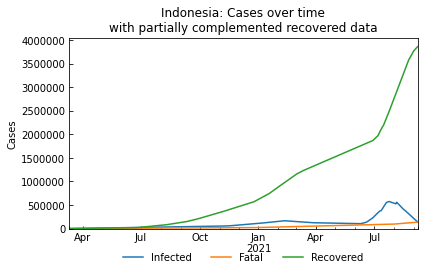

,Date,Infected,Fatal,Recovered
542,2021-09-03,174293,134930,3807667
543,2021-09-04,161825,135469,3826323
544,2021-09-05,151453,135861,3841706
545,2021-09-06,143876,136473,3853084
546,2021-09-07,141632,137156,3861846


In [4]:
# Check records
df = snl.records()
df.tail()

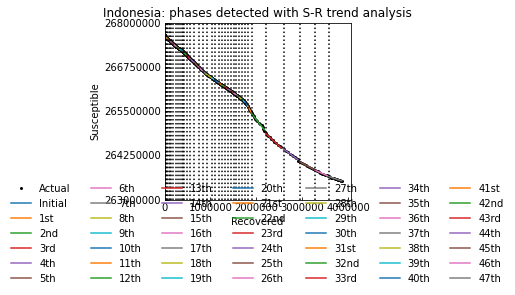

In [5]:
_ = snl.trend()

In [6]:
snl.summary().tail()

,Type,Start,End,Population
43rd,Past,16Jul2021,26Jul2021,267663435
44th,Past,27Jul2021,05Aug2021,267663435
45th,Past,06Aug2021,13Aug2021,267663435
46th,Past,14Aug2021,23Aug2021,267663435
47th,Past,24Aug2021,07Sep2021,267663435


In [7]:
# Parameter estimation of SIR-F model
snl.estimate(cs.SIR)


<SIR model: parameter estimation>
Running optimization with 2 CPUs...
	 0th phase (10Mar2020 - 21Mar2020): finished  275 trials in 0 min  7 sec
	 6th phase (15May2020 - 27May2020): finished  338 trials in 0 min  9 sec
	 1st phase (22Mar2020 - 30Mar2020): finished  164 trials in 0 min  4 sec
	 7th phase (28May2020 - 10Jun2020): finished  341 trials in 0 min  9 sec
	 2nd phase (31Mar2020 - 07Apr2020): finished  307 trials in 0 min  8 sec
	 8th phase (11Jun2020 - 24Jun2020): finished  287 trials in 0 min  7 sec
	 9th phase (25Jun2020 - 06Jul2020): finished   49 trials in 0 min  1 sec
	 3rd phase (08Apr2020 - 15Apr2020): finished  346 trials in 0 min  9 sec
	10th phase (07Jul2020 - 18Jul2020): finished  173 trials in 0 min  4 sec
	11th phase (19Jul2020 - 29Jul2020): finished   49 trials in 0 min  1 sec
	12th phase (30Jul2020 - 12Aug2020): finished   51 trials in 0 min  1 sec
	 4th phase (16Apr2020 - 29Apr2020): finished  250 trials in 0 min  6 sec
	13th phase (13Aug2020 - 27Aug2020): fini

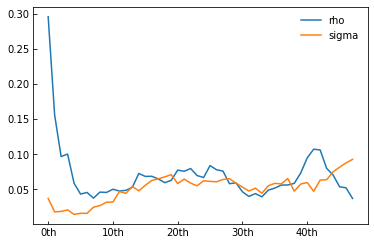

In [14]:
sumdf = snl.summary()
sumdf[["rho", "sigma"]].plot()

In [15]:
sumdf.to_csv("estimated.csv")